In [4]:
#UAL CDS reduce form term structure 

#import libraries 

import numpy as np
import pandas as pd
import math
from datetime import datetime
from dataclasses import dataclass
from typing import Union, Optional, Tuple
from pathlib import Path
from scipy.optimize import minimize
import pandas as pd


#=================================================

#funct for loading cds files 

def x_files(path: Union[str, Path]) -> pd.DataFrame:
    
    xl = pd.ExcelFile(path)
    
    for sheet in xl.sheet_names:
        
        try:
            
            df = xl.parse(sheet)
            df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
            
            return df
        
        except Exception:
            continue
            
    return pd.read_excel(path)


files = {
    
    "cds_hist": "/Users/anthonygiller/Downloads/CDS Historical Prices UAL.xlsx",
    "cds_histogram": "/Users/anthonygiller/Downloads/CDS Histogram of Returns.xlsx",
    "cds_term": "/Users/anthonygiller/Downloads/CDS_term_structure_UAL.xlsx",
    "ts_1": "/Users/anthonygiller/Downloads/Term_structure_08.20_1M.xlsx",
    "ts_2": "/Users/anthonygiller/Downloads/Term_structure_10.25_1M.xlsx",
    "cds_5y_pricing": "/Users/anthonygiller/Downloads/UAL_CDS_5Y_Pricing.xlsx",
}

loaded = {}

for k, p in files.items():
    
    if Path(p).exists():
        try:
            
            loaded[k] = x_files(p)
            
        except Exception:
            loaded[k] = None

            
#=================================================            

#discount curve 

#using dataclass library 

@dataclass

class zcurve:
    
    #pillar dates
    
    dates: pd.Series            
    
    #zero rates
    
    zr:    pd.Series            
    val_date: pd.Timestamp

    def df(self, t_years: float) -> float:
        
        times = (self.dates - self.val_date).dt.days.values / 365.0
        r = np.interp(t_years, times, self.zr.values, left=self.zr.iloc[0], right=self.zr.iloc[-1])
        
        return float(np.exp(-r * t_years))

   
    def df_at(self, date: pd.Timestamp) -> float:
        
        t = (date - self.val_date).days / 365.0
        
        return self.df(t)

def zcurve_df(df: pd.DataFrame, val_date: Optional[pd.Timestamp]=None) -> Optional[zcurve]:
    
    d = df.copy()
    
    low = {c.lower(): c for c in d.columns}
    date_col = next((low[c] for c in ["date","maturity","pillar","as_of_date","end_date"] if c in low), None)
    rate_col = next((low[c] for c in ["zero","zero_rate","rate","yield","ois","rf","z"] if c in low), None)
    
    if not date_col or not rate_col:
        return None
    
    d = d[[date_col, rate_col]].dropna()
    d[date_col] = pd.to_datetime(d[date_col])
    rates = pd.to_numeric(d[rate_col], errors="coerce")
    
    #changing %s to decimals 
    
    if rates.dropna().mean() > 0.5:
        rates = rates / 100.0
        
    if val_date is None:
        
        val_date = d[date_col].min()
        
    return zcurve(dates=d[date_col].reset_index(drop=True),
                     zr=rates.reset_index(drop=True),val_date=pd.to_datetime(val_date))

zc = None

for key in ["ts_1","ts_2"]:
    
    if key in loaded and loaded[key] is not None:
        
        zc = zcurve_df(loaded[key])
        if zc is not None:
            
            break

#flat curve if not parsing 

if zc is None:
    
    vd = pd.Timestamp("2015-09-03")
    
    zc = zcurve(dates=pd.Series(pd.to_datetime([vd + pd.DateOffset(years=i) for i in [1,3,5,7,10]])),
                   zr=pd.Series([0.015,0.017,0.019,0.020,0.021]),
                   val_date=vd)

vl_date = zc.val_date

#=================================================

#cds term structure 

def term_st(df: pd.DataFrame) -> pd.DataFrame:
    
    d = df.copy()
    d.columns = [str(c).strip().lower() for c in d.columns]
    
    ten_cols  = [c for c in d.columns if any(tok in c for tok in ["tenor","maturity","years","yr","y"])]
    sp_cols = [c for c in d.columns if any(tok in c for tok in ["spread","cds","bps","rate"])]
    
    if not ten_cols or not sp_cols:
        
        return pd.DataFrame()
    
    tcol = ten_cols[0]; scol = sp_cols[0]
    
    out = d[[tcol, scol]].rename(columns={tcol:"tenor_yrs", scol:"cds_bps"}).dropna()
    out["tenor_yrs"] = pd.to_numeric(out["tenor_yrs"], errors="coerce")
    out["cds_bps"]   = pd.to_numeric(out["cds_bps"], errors="coerce")
    out = out.dropna().sort_values("tenor_yrs").reset_index(drop=True)
    
    #if spread %s - bps 
    
    if out["cds_bps"].mean() < 2.0:
        out["cds_bps"] *= 1e4
        
    return out

cds_curve_df = None

if "cds_term" in loaded and loaded["cds_term"] is not None:
    
    tmp = term_st(loaded["cds_term"])
    
    if not tmp.empty:
        
        cds_curve_df = tmp

        
if cds_curve_df is None and "cds_5y_pricing" in loaded and loaded["cds_5y_pricing"] is not None:
    
    tmp = term_st(loaded["cds_5y_pricing"])
    
    if not tmp.empty:
        
        cds_curve_df = tmp

if cds_curve_df is None or cds_curve_df.empty:
    
    cds_curve_df = pd.DataFrame({"tenor_yrs":[1,3,5,7,10], "cds_bps":[90,130,160,185,210]})


#=================================================

#cds schedule functs

def cds_sched(val_date: pd.Timestamp, T_y: float, pay_freq: int = 4) -> pd.DataFrame:
    
    n = int(math.ceil(T_y * pay_freq))
    
    dates = [val_date + pd.DateOffset(months=int(12/pay_freq * (i+1))) for i in range(n)]
    
    tau = np.array([(d - val_date).days/365.0 for d in dates], dtype=float)
    accr = []; prev = val_date
    
    for d in dates:
        
        accr.append((d - prev).days/360.0)  
        prev = d
        
    return pd.DataFrame({"pay_date": pd.to_datetime(dates), "tau": tau, "accrual": accr})


#survival based cds pricing 

def cds_surv(schedule: pd.DataFrame, Q: np.ndarray, recov: float, zc: zcurve) -> float:
    
    Q = np.clip(np.asarray(Q, float), 0.0, 1.0)
    Q_prev = np.r_[1.0, Q[:-1]]
    
    DFs = np.array([zc.df_at(d) for d in schedule["pay_date"]], dtype=float)
    accr = schedule["accrual"].values
    
    LGD = 1.0 - recov
    denom = np.sum(Q * accr * DFs)
    prot  = np.sum(LGD * DFs * (Q_prev - Q))
    
    if denom <= 1e-14:    
        return np.nan
    
    #in bps 
    
    return float((prot/denom) * 1e4)  

#=================================================

#hazard - nelson siegel 

def hazard_ns(t: np.ndarray, theta: np.ndarray) -> np.ndarray:
    
    b0, b1, b2, tau = theta
    tau = max(tau, 1e-6)
    x = t / tau
    raw = b0 + b1*np.exp(-x) + b2*(x*np.exp(-x))
    
    return np.log1p(np.exp(raw))


def sur_hzrd(sched_t: np.ndarray, theta: np.ndarray, n_sub: int = 8) -> np.ndarray:
    
    t_grid = np.asarray(sched_t, float)
    Q = np.zeros_like(t_grid)
    expo = 0.0; t_prev = 0.0
    
    for i, t_i in enumerate(t_grid):
        
        if t_i <= t_prev + 1e-12:
            
            Q[i] = math.exp(-expo); t_prev = t_i; continue
            
        xs   = np.linspace(t_prev, t_i, n_sub+1)
        mids = 0.5*(xs[:-1] + xs[1:])
        hmid = hazard_ns(mids, theta)
        
        expo += np.sum(hmid * (xs[1:] - xs[:-1]))
        Q[i] = math.exp(-expo); t_prev = t_i
    
    return Q

#=================================================

#fit to observed cds 

def hzrd_to_cds(val_date: pd.Timestamp,cds_curve_df: pd.DataFrame,zc: zcurve,
    
    recov: float = 0.4,
    pay_freq: int = 4,
    
    theta0: np.ndarray = np.array([-3, 0.5, -0.5, 2])  
) -> Tuple[np.ndarray, pd.DataFrame]:
    
    tenors = cds_curve_df["tenor_yrs"].values.astype(float)
    quotes = cds_curve_df["cds_bps"].values.astype(float)
    
    sched_s = [cds_sched(val_date, T, pay_freq) for T in tenors]

    
    def obj(theta):
        
        errs = []
        
        for sched, s_mkt in zip(sched_s, quotes):
            
            Q = sur_hzrd(sched["tau"].values, theta)
            s_model = cds_surv(sched, Q, recov, zc)
            errs.append((s_model - s_mkt)**2)
            
        return float(np.mean(errs))

    res = minimize(obj, theta0, method="Nelder-Mead",
                   options={"maxiter": 8000, "xatol": 1e-8, "fatol": 1e-8})
    
    t_hat = res.x

    rows = []
    
    for T, sched, s_mkt in zip(tenors, sched_s, quotes):
        
        Q = sur_hzrd(sched["tau"].values, t_hat)
        s_model = cds_surv(sched, Q, recov, zc)
        
        rows.append({"tenor_yrs": T, "cds_bps_mkt": s_mkt, "cds_bps_model": s_model, "abs_err_bps": s_model - s_mkt})
    
    return t_hat, pd.DataFrame(rows).sort_values("tenor_yrs").reset_index(drop=True)

#=================================================

#running 

vl_date = zc.val_date
t_hat, comp = hzrd_to_cds(vl_date, cds_curve_df, zc, recov=0.4, pay_freq=4)


#surv curve 

Tmax = float(cds_curve_df["tenor_yrs"].max())
sched_d = cds_sched(vl_date, Tmax, 4)
Q_d = sur_hzrd(sched_d["tau"].values, t_hat)

#market - model comparison 

m_rows = []

for T in cds_curve_df["tenor_yrs"]:
    
    sched_T = cds_sched(vl_date, float(T), 4)
    Q_T = sur_hzrd(sched_T["tau"].values, t_hat)
    
    s_par = cds_surv(sched_T, Q_T, 0.4, zc)
    m_rows.append({"tenor_yrs": float(T), "model_par_bps": s_par})
    
m_par_df = pd.DataFrame(m_rows)


#merging for errs 

comp = cds_curve_df.merge(m_par_df, on="tenor_yrs", how="left")

#calculating err and abs err

comp["err_bps"] = comp["model_par_bps"] - comp["cds_bps"]
comp["abs_err_bps"] = comp["err_bps"].abs()


#=================================================

#saving curve and term sturcture csv's 

curve_p = "/Users/anthonygiller/Downloads/UAL_CDS_fitted_survival_curve.csv"
comp_p  = "/Users/anthonygiller/Downloads/UAL_CDS_termstructure_fit_vs_market.csv"

pd.DataFrame({"pay_date": sched_d["pay_date"],"tau_years": sched_d["tau"],
              "Q_survival": Q_d}).to_csv(curve_p, index=False)

comp.to_csv(comp_p, index=False)


#printing term struct and model vs market  

print("\nMarket CDS term structure")
print(cds_curve_df.to_string(index=False))

print("\nModel vs Market (bps)")
print(comp.to_string(index=False))

#save paths for csv's 

print(f"\nsurvival curve saved to: {curve_p}")
print(f"model vs market table saved to: {comp_p}")




Market CDS term structure
 tenor_yrs  cds_bps
         1       90
         3      130
         5      160
         7      185
        10      210

Model vs Market (bps)
 tenor_yrs  cds_bps  model_par_bps   err_bps  abs_err_bps
         1       90      90.495855  0.495855     0.495855
         3      130     128.707592 -1.292408     1.292408
         5      160     160.924047  0.924047     0.924047
         7      185     185.213102  0.213102     0.213102
        10      210     209.680334 -0.319666     0.319666

survival curve saved to: /Users/anthonygiller/Downloads/UAL_CDS_fitted_survival_curve.csv
model vs market table saved to: /Users/anthonygiller/Downloads/UAL_CDS_termstructure_fit_vs_market.csv


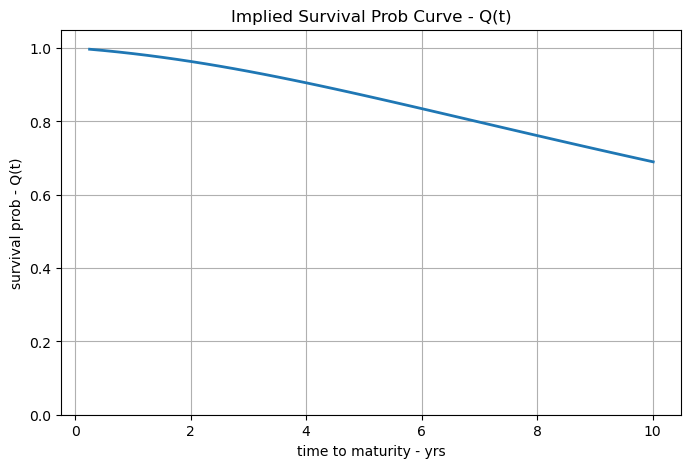

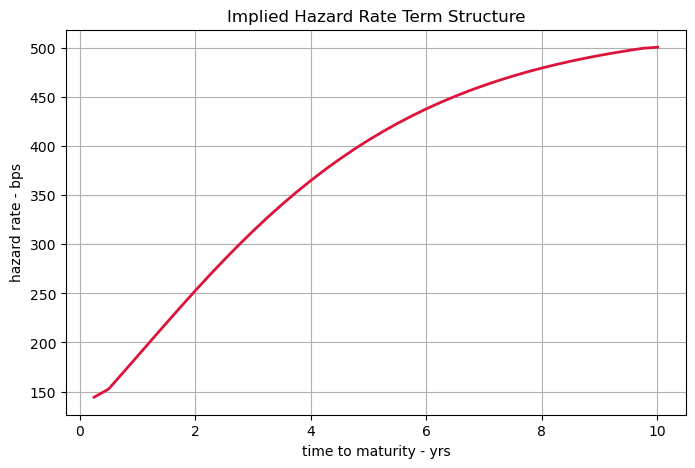

In [5]:
#plotting survival prob curve and hzrd term structure 

#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#=================================================

#loading saved curve csv from above 

curve = "/Users/anthonygiller/Downloads/UAL_CDS_fitted_survival_curve.csv"
df = pd.read_csv(curve)

#calculating hzrd 

df['lambda'] = -np.gradient(np.log(df['Q_survival']), df['tau_years'])

#=================================================

#plotting survival prob curve 

plt.figure(figsize=(8, 5))
plt.plot(df['tau_years'], df['Q_survival'], lw=2)

plt.title("Implied Survival Prob Curve - Q(t)")
plt.xlabel("time to maturity - yrs")
plt.ylabel("survival prob - Q(t)")

plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

#plotting hzrd rate 

plt.figure(figsize=(8, 5))

#converting to bps 

plt.plot(df['tau_years'], df['lambda'] * 10000, lw=2, color='crimson')  
plt.title("Implied Hazard Rate Term Structure")
plt.xlabel("time to maturity - yrs")
plt.ylabel("hazard rate - bps")

plt.grid(True)
plt.show()

